<a href="https://colab.research.google.com/github/Firojpaudel/Machine-Learning-Notes/blob/main/Practical%20Deep%20Learning%20For%20Coders/Chapter_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training a State-of-the-Art Model

This notebook explores advanced techniques for training an image classification model. We will use the **Imagenette dataset** and progressively apply methods to achieve state-of-the-art results.  

## **Objectives**:

- Understand the challenges of training from scratch.
- Learn about techniques like normalization, Mixup, progressive resizing, and Test Time Augmentation (TTA).
- Prototype and evaluate models using a simplified ImageNet subset: **Imagenette**.

---

### **1. Introduction to Imagenette**

#### Qn1. Why Imagenette?


Imagenette is a subset of ImageNet with 10 very distinct categories. It was designed to:  
- Enable quick experimentation while retaining real-world complexities.  
- Serve as a middle ground between small datasets like MNIST/CIFAR10 and large datasets like ImageNet.  


#### Qn2. Its Benefits?


- **Fast Prototyping**: Reduced dataset size allows iteration within minutes, enabling quicker testing and refinement of ideas.  
- **Real-World Insights**: Imagenette retains enough complexity to provide insights that generalize well to larger datasets like ImageNet.  
- **Resource Efficiency**: Enables meaningful experimentation without requiring expensive computational resources.

#### Key Takeaway:

_The dataset you are given is not always ideal for prototyping._  
To maximize efficiency:
- Reduce dataset size for faster experimentation.
- Iterate quickly to test and refine ideas.  
---

In [1]:
### Setting up the notebook
##@ Notebook initialization
%reload_ext autoreload
%autoreload 2
%matplotlib inline

##@ Installing dependencies
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

##@ Importing the necessary libraries
from fastbook import *
from fastai.callback.fp16 import *
from fastai.vision.all import *

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 29.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
Mounted at /content/gdrive


### **2. Preparing the Data**

In [2]:
'''
  After the Notebook is setup, preparing the Imagenette Dataset
'''
path = untar_data(URLs.IMAGENETTE)

We'll use the **DataBlock API** to preprocess the images and create a `DataLoaders` object.  


#### Key Steps:


1. **Presizing**: Resize images to 460 pixels to improve data augmentation.  
2. **Augmentations**: Apply standard augmentations (introduced in Chapter 5).  
3. **Batch Transformations**: Resize images to 224 pixels for training.  
---

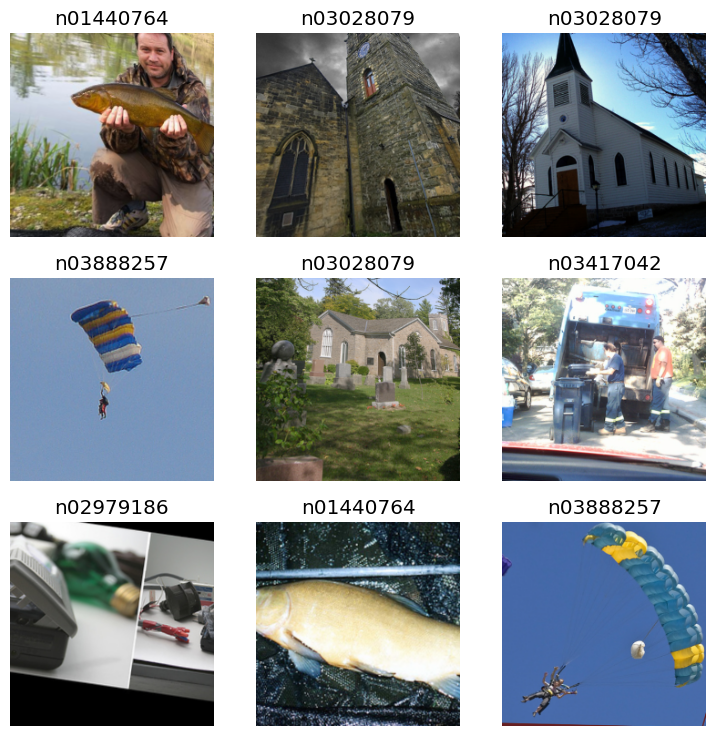

In [3]:
##@ Creating DataBlock and DataLoaders
dblock = DataBlock(
    blocks=(ImageBlock(), CategoryBlock()),  # Image inputs and categorical labels
    get_items=get_image_files,  # Retrieve image files
    get_y=parent_label,  # Use parent folder name as label
    item_tfms=Resize(460),  # Resize images to 460 pixels
    batch_tfms=aug_transforms(size=224, min_scale=0.75)  # Apply augmentations
)

dls = dblock.dataloaders(path, bs=64)  # Create DataLoaders with batch size 64
dls.show_batch()  # Display a batch of images


### **3. Training a Baseline Model**




We will train a baseline model without using pretrained weights. This will serve as a reference point for later comparisons.


#### Model Architecture:


<ul><code>xResNet50</code>: A modified ResNet50 architecture designed for fastai.  </ul>

##### Steps:
1. Create a model using `xResNet50`.
2. Use the **CrossEntropyLoss** for multi-class classification.
3. Measure accuracy as the evaluation metric.
4. Train the model for 5 epochs using the **1-cycle policy**.
---

In [4]:
##@ Baseline Training
model = xresnet50()  # Define the model
learn = Learner(
    dls, model,
    loss_func=CrossEntropyLossFlat(),
    metrics=accuracy  # Use accuracy as the evaluation metric
)

learn.fit_one_cycle(5, 3e-3)  # Train the model for 5 epochs

epoch,train_loss,valid_loss,accuracy,time
0,1.611839,2.608399,0.412248,03:14
1,1.216729,1.493393,0.512323,03:00
2,0.932032,0.958456,0.692681,02:55
3,0.697012,0.751739,0.761762,03:00
4,0.556221,0.578841,0.820762,02:53


### **4. Why Advanced Techniques Are Necessary**

While the baseline model performs reasonably well, additional methods can:
- Boost performance further, especially when training from scratch.
- Adapt pretrained models to datasets with characteristics different from the original pretraining dataset.  

---

Its a good baseline, since we are not using a pretrained model, but we can do better.

When working with models that are being trained from scratch or fine tuned to different dataset from the one used for pretraining, some additional techniques are important.

And we go on exploring those.

### **Techinique 1: Normalization**

##### A. What is Normalization?

Normalization is a process where input data is adjusted to have:
- **Mean ≈ 0**  
- **Standard Deviation ≈ 1**



##### B. Why Normalize?


- Most image datasets use pixel values between 0 and 255 or 0 and 1, which means they do not meet the desired mean and standard deviation for effective training.  
- Normalization ensures that the model receives inputs with consistent distribution, improving convergence during training.

---

In [5]:
##@ Before Normalizing, Examining the mean and standard deviation

x,y = dls.one_batch()
x.mean(dim=[0,2,3]), x.std(dim=[0,2,3])   #Calculating mean and std accross axes except channel (axis-1)

(TensorImage([0.4340, 0.4321, 0.4006], device='cuda:0'),
 TensorImage([0.2845, 0.2727, 0.2910], device='cuda:0'))

These values are not close to 0 and 1, indicating the need for normalization

##### C. Applying Normalization


fastai provides an easy way to normalize using the `Normalize` transform:
- We will use **`imagenet_stats`**, which contains the mean and standard deviation values for the ImageNet dataset (appropriate since Imagenette is a subset of ImageNet).

In [6]:
##@ Redefining DataLoaders with Normalization

def get_dls(bs, size):
  dblock = DataBlock(
        blocks=(ImageBlock, CategoryBlock),  # Image input and category labels
        get_items=get_image_files,  # Retrieve image files
        get_y=parent_label,  # Labels from parent directory names
        item_tfms=Resize(460),  # Resize images to 460px
        batch_tfms=[
            *aug_transforms(size=size, min_scale=0.75),  # Augmentations
            Normalize.from_stats(*imagenet_stats)  # Normalize using ImageNet stats
        ]
    )
  return dblock.dataloaders(path, bs=bs)

dls = get_dls(64, 224)  # Create DataLoaders with batch size 64 and 224px size

<details>
  <summary>
    <b>
      <code>*aug_transforms(...)</code> and  <code>*imagenet_stats</code> explanation:
    </b>
  </summary>

<ol type="a"><li><code>*aug_transforms(...)</code> Explanation:</li>
<ul>
<li><code>aug_transforms</code> is a function that returns a list of data augmentation transforms.</li>
<li>The <code>*</code> before </code>aug_transforms(...)</code> unpacks this list so that its elements are included individually within batch_tfms.</li>
Without the <code>*</code>, the entire output of aug_transforms would be treated as a single element (a list), instead of individual transformations.
With the <code>*</code>, it ensures that each transformation gets added to batch_tfms separately.
</ul>

<li><code>*imagenet_stats</code> Explanation:</li>
<ul>
<li><code>imagenet_stats</code> is a tuple containing two elements: the mean and standard deviation for ImageNet, typically like <code>(mean, std)</code></li>
<li>The <code>Normalize.from_stats()</code> function expects two separate arguments: <code> mean</code> and <code>std</code></li>
Using <code>*imagenet_stats</code> unpacks the tuple so that the <code>mean</code> and <code>std</code> are passed as individual arguments.
</ul>
</ol>
</details>

In [7]:
##@ Checking Mean and Standard Deviation After Normalization
x, y = dls.one_batch()
x.mean(dim=[0, 2, 3]), x.std(dim=[0, 2, 3])  # Recalculating...

(TensorImage([-0.0914,  0.0639,  0.1908], device='cuda:0'),
 TensorImage([1.2302, 1.2055, 1.3002], device='cuda:0'))

Normalization has adjusted the input data closer to the desired distribution, which will help the model train more effectively.

---

##### D. Training  the Model with Normalization

We will now retrain the model using the normalized data and compare the results with the baseline.

<details>
  <summary>
    <b>
      Training Steps:
    </b>
  </summary>
<ul>
  <li>Using <b>xResNet50</b> again, but this time with normalized inputs.</li>
  <li>Training for 5 epochs using the same learning rate (<code>3e-3</code>).</li>
</ul>
</details>

In [8]:
##@ Training the Model with Normalized Data
model = xresnet50()
learn = Learner(
    dls, model,
    loss_func=CrossEntropyLossFlat(),
    metrics=accuracy
)

learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.635915,1.716189,0.482823,02:56
1,1.264106,1.552658,0.460045,02:57
2,0.951965,0.880574,0.724795,02:50
3,0.724904,0.720378,0.762883,02:48
4,0.592311,0.532050,0.836072,02:49


##### E. Comparison and Insights

- **Improved Accuracy**: Accuracy has improved slightly than before.
- **Stability**: Loss values decrement is a bit more consistent.

### **Technique 2: Progressive Resizing**

##### A. What is Progressive Resizing?

**Progressive Resizing** is a technique where training starts with small images and gradually transitions to larger images. It offers two main benefits:  
1. **Faster Training**: Small images reduce computation time for most epochs.  
2. **Higher Accuracy**: Training with large images towards the end improves the model's final performance.  


> **Jargon: Progressive Resizing**  
> Gradually using larger images throughout training.

##### B. Why Does it Work?

- **CNNs Learn General Features**: Convolutional Neural Networks (CNNs) learn features like edges and shapes, which are independent of image size.
- **Similarity to Transfer Learning**: Changing image sizes is similar to transfer learning. The model adjusts to new data characteristics using the previously learned features.

Progressive resizing also serves as an additional **data augmentation** technique, improving generalization.

***

##### C. Implemetation in Fast.ai

We need a reusable function that adjusts image and batch sizes. This builds on the `get_dls` function introduced earlier

In [9]:
#### Step 1: Training with Small Images
dls = get_dls(bs=128, size=128)  # Batch size: 128, Image size: 128x128
learn = Learner(
    dls,
    xresnet50(),
    loss_func=CrossEntropyLossFlat(),
    metrics=accuracy
)
learn.fit_one_cycle(4, 3e-3)  # Train for 4 epochs

epoch,train_loss,valid_loss,accuracy,time
0,1.846203,3.039289,0.329724,02:24
1,1.275339,1.326992,0.571695,02:21
2,0.978028,0.815548,0.737117,02:20
3,0.748154,0.680341,0.783047,02:22


In [10]:
#### Step 2: Fine-Tuning with Larger Images
learn.dls = get_dls(bs=64, size=224)  # Batch size: 64, Image size: 224x224
learn.fine_tune(5, 1e-3)  # Fine-tune for 5 epochs

epoch,train_loss,valid_loss,accuracy,time
0,0.852553,0.856141,0.728529,02:49


epoch,train_loss,valid_loss,accuracy,time
0,0.669698,0.661632,0.795743,02:50
1,0.663705,0.788842,0.760642,02:46
2,0.610140,0.594224,0.817401,02:48
3,0.516430,0.468097,0.854742,02:51
4,0.442724,0.446299,0.858850,02:48


As seen, the initial training on small images is faster, and the final accuracy improves after fine-tuning with larger images.



<details>
<summary>
Authors POV: <br>
<b><q>When to Use Progressive Resizing</q></b>
</summary>
<ul>
<li><b>Helpful:</b> When training from scratch or when the dataset differs significantly from the pretraining dataset.</li>
<li><b>Potential Drawback:</b> May harm performance in transfer learning if the pretraining task and dataset are similar to the fine-tuning task.</li>
</ul>
<blockquote>Tip: <i>Always experiment!</i> Try progressive resizing and observe its effects on your dataset.</blockquote>
</details>

***